# Denoising Diffusion Probabilistic Models (DDPM)
## A Pedagogical Introduction with 2D Toy Data

This notebook provides an in-depth, visual introduction to **Denoising Diffusion Probabilistic Models (DDPM)**, one of the foundational architectures behind modern generative models like DALL-E 2, Stable Diffusion, and others.



## 1. Intuition: The Core Idea

Diffusion models are based on a simple yet powerful idea:

1. **Forward Process (Destroy Structure):** Gradually add noise to data until it becomes pure Gaussian noise
2. **Reverse Process (Learn to Denoise):** Train a neural network to reverse this process step-by-step

```
Data x₀ → x₁ → x₂ → ... → x_T ≈ N(0, I)   [Forward: Add Noise]
         ←    ←    ←  ...  ←               [Reverse: Denoise]
```

### Why does this work?

- The forward process is **fixed** and simple (just adding Gaussian noise)
- Each denoising step is a **small** change, making it easier to learn
- The reverse process learns the **score function** ∇ₓ log p(x), which points toward high-density regions

## 2. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Using device: cpu


## 3. Toy Dataset: 2D Spiral

We'll use a 2D spiral dataset. This is a classic toy dataset for generative models because:
- It's **low-dimensional** (easy to visualize)
- It has **complex structure** (non-convex, non-Gaussian)
- It clearly shows whether the model captures the data distribution

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


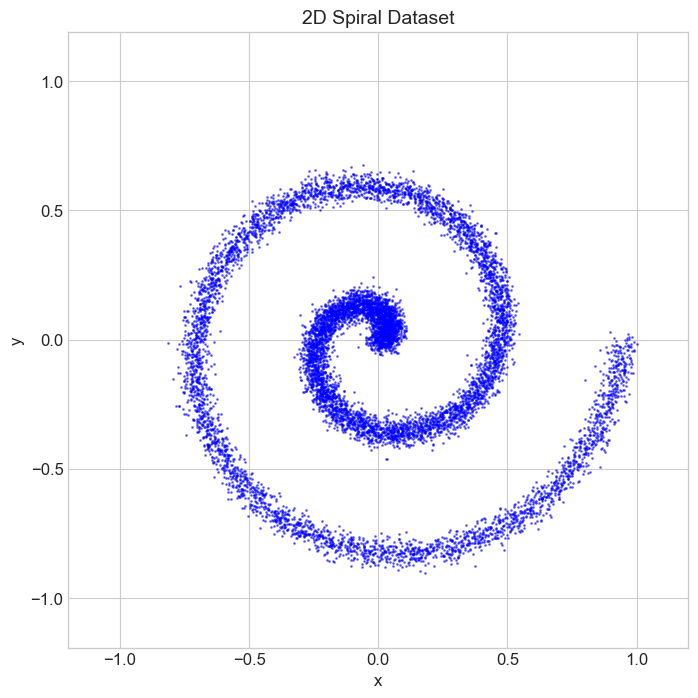

Dataset shape: (10000, 2)
Data range: [-0.905, 1.000]


In [2]:
def generate_spiral_data(n_samples=10000, noise=0.05):
    """
    Generate a 2D spiral dataset.
    
    Args:
        n_samples: Number of points to generate
        noise: Standard deviation of Gaussian noise added to points
    
    Returns:
        X: numpy array of shape (n_samples, 2)
    """
    # Parameter t controls position along the spiral
    t = np.linspace(0, 4 * np.pi, n_samples)
    
    # Spiral equations: r increases with t
    r = t / (4 * np.pi)  # Normalize radius to [0, 1]
    x = r * np.cos(t)
    y = r * np.sin(t)
    
    # Stack into (n_samples, 2) array
    X = np.stack([x, y], axis=1)
    
    # Add noise
    X += noise * np.random.randn(n_samples, 2)
    
    # Normalize to roughly [-1, 1]
    X = X / np.abs(X).max()
    
    return X.astype(np.float32)

# Generate data
X_train = generate_spiral_data(n_samples=10000, noise=0.03)

# Visualize
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.5, c='blue')
plt.title('2D Spiral Dataset', fontsize=14)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.show()

print(f"Dataset shape: {X_train.shape}")
print(f"Data range: [{X_train.min():.3f}, {X_train.max():.3f}]")

## 4. The Forward Diffusion Process

### Mathematical Formulation

The forward process is a **Markov chain** that gradually adds Gaussian noise to the data over $T$ timesteps:

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} \, x_{t-1}, \beta_t \mathbf{I})$$

where $\beta_t$ is the **noise schedule** (how much noise to add at each step).

### Key Insight: Closed-Form Solution

We can sample $x_t$ directly from $x_0$ without iterating through all intermediate steps:

$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} \, x_0, (1 - \bar{\alpha}_t) \mathbf{I})$$

where:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$ (cumulative product)

This can be written using the **reparameterization trick**:

$$x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})$$

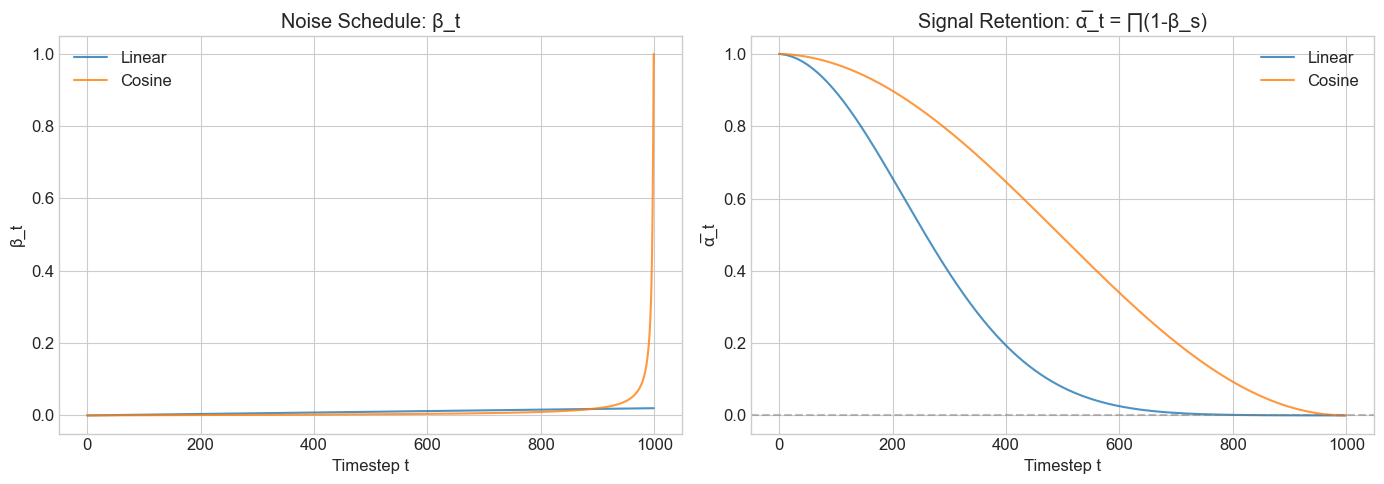


Interpretation:
- α̅_t ≈ 1 means x_t ≈ x_0 (mostly signal)
- α̅_t ≈ 0 means x_t ≈ noise (mostly noise)

Linear schedule: α̅_T = 0.000040
Cosine schedule: α̅_T = 0.000000


In [3]:
def linear_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    """
    Linear noise schedule from beta_start to beta_end.
    This is the original schedule from Ho et al. (2020).
    """
    return torch.linspace(beta_start, beta_end, T)


def cosine_beta_schedule(T, s=0.008):
    """
    Cosine noise schedule from Nichol & Dhariwal (2021).
    Provides smoother noise addition, especially at early timesteps.
    """
    steps = torch.linspace(0, T, T + 1)
    alpha_bar = torch.cos(((steps / T) + s) / (1 + s) * (math.pi / 2)) ** 2
    alpha_bar = alpha_bar / alpha_bar[0]
    betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return torch.clamp(betas, 0, 0.999)


# Compare schedules
T = 1000
linear_betas = linear_beta_schedule(T)
cosine_betas = cosine_beta_schedule(T)

# Compute alpha_bar for both
linear_alpha_bar = torch.cumprod(1 - linear_betas, dim=0)
cosine_alpha_bar = torch.cumprod(1 - cosine_betas, dim=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot beta schedules
axes[0].plot(linear_betas.numpy(), label='Linear', alpha=0.8)
axes[0].plot(cosine_betas.numpy(), label='Cosine', alpha=0.8)
axes[0].set_xlabel('Timestep t')
axes[0].set_ylabel('β_t')
axes[0].set_title('Noise Schedule: β_t')
axes[0].legend()

# Plot alpha_bar (signal retention)
axes[1].plot(linear_alpha_bar.numpy(), label='Linear', alpha=0.8)
axes[1].plot(cosine_alpha_bar.numpy(), label='Cosine', alpha=0.8)
axes[1].set_xlabel('Timestep t')
axes[1].set_ylabel('α̅_t')
axes[1].set_title('Signal Retention: α̅_t = ∏(1-β_s)')
axes[1].legend()
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- α̅_t ≈ 1 means x_t ≈ x_0 (mostly signal)")
print("- α̅_t ≈ 0 means x_t ≈ noise (mostly noise)")
print(f"\nLinear schedule: α̅_T = {linear_alpha_bar[-1]:.6f}")
print(f"Cosine schedule: α̅_T = {cosine_alpha_bar[-1]:.6f}")

In [4]:
def compute_diffusion_coefficients(betas):
    """
    Compute all diffusion coefficients from the beta schedule.
    
    Args:
        betas: Tensor of beta values, shape (T,)
    
    Returns:
        Dictionary with alphas, alpha_cumprod, sqrt values, etc.
    """
    alphas = 1.0 - betas
    alpha_cumprod = torch.cumprod(alphas, dim=0)
    
    return {
        'betas': betas,
        'alphas': alphas,
        'alpha_cumprod': alpha_cumprod,
        'sqrt_alpha_cumprod': torch.sqrt(alpha_cumprod),
        'sqrt_one_minus_alpha_cumprod': torch.sqrt(1 - alpha_cumprod),
    }


def q_sample(x_0, t, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod, noise=None):
    """
    Sample x_t from q(x_t | x_0) using the reparameterization trick.
    
    x_t = sqrt(α̅_t) * x_0 + sqrt(1 - α̅_t) * ε
    
    Args:
        x_0: Original data, shape (batch, dim)
        t: Timesteps, shape (batch,)
        sqrt_alpha_cumprod: Precomputed sqrt(α̅)
        sqrt_one_minus_alpha_cumprod: Precomputed sqrt(1 - α̅)
        noise: Optional pre-sampled noise
    
    Returns:
        x_t: Noised data at timestep t
        noise: The noise that was added
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    
    sqrt_alpha_bar_t = sqrt_alpha_cumprod[t].view(-1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_cumprod[t].view(-1, 1)
    
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise


# Create diffusion coefficients for visualization
T_viz = 1000
betas_viz = linear_beta_schedule(T_viz)
coeffs = compute_diffusion_coefficients(betas_viz)

print(f"Diffusion process initialized with T={T_viz} steps")
print(f"α̅_0 = {coeffs['alpha_cumprod'][0]:.4f}")
print(f"α̅_T = {coeffs['alpha_cumprod'][-1]:.6f}")

Diffusion process initialized with T=1000 steps
α̅_0 = 0.9999
α̅_T = 0.000040


### Visualizing the Forward Process

Let's see how the spiral data gets progressively destroyed as we add noise:

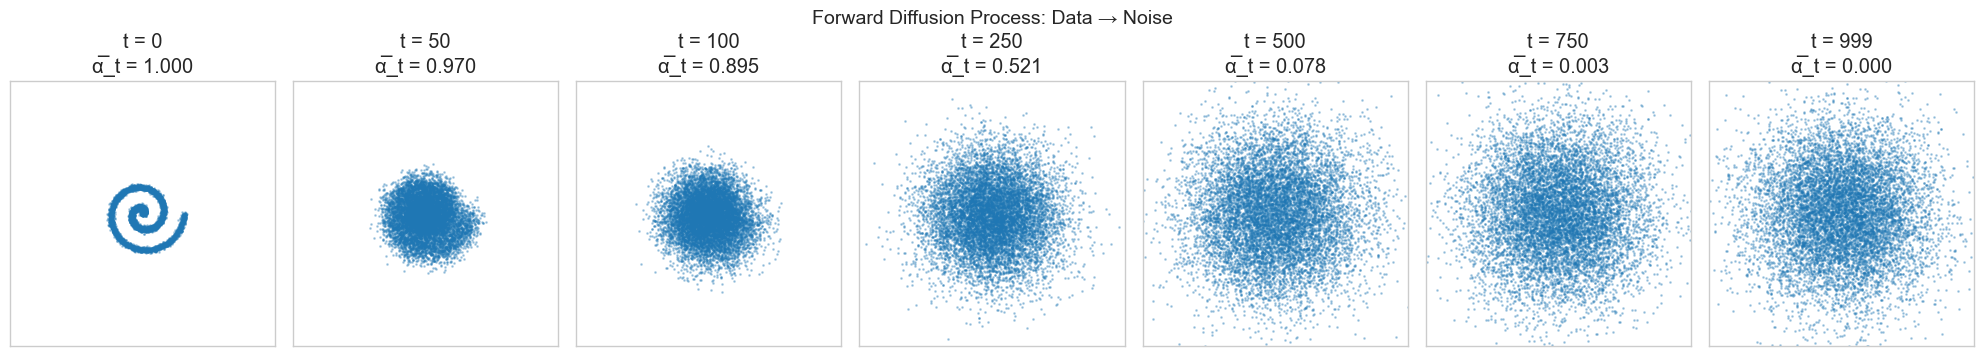

In [5]:
# Convert data to tensor
X_tensor = torch.from_numpy(X_train)

# Select timesteps to visualize
timesteps_to_show = [0, 50, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 3.5))

for idx, t in enumerate(timesteps_to_show):
    # Create timestep tensor
    t_tensor = torch.full((X_tensor.shape[0],), t, dtype=torch.long)
    
    # Sample x_t
    if t == 0:
        x_t = X_tensor
    else:
        x_t, _ = q_sample(X_tensor, t_tensor, 
                          coeffs['sqrt_alpha_cumprod'], 
                          coeffs['sqrt_one_minus_alpha_cumprod'])
    
    # Plot
    x_t_np = x_t.numpy()
    axes[idx].scatter(x_t_np[:, 0], x_t_np[:, 1], s=1, alpha=0.3)
    axes[idx].set_title(f't = {t}\nα̅_t = {coeffs["alpha_cumprod"][t]:.3f}')
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_aspect('equal')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.suptitle('Forward Diffusion Process: Data → Noise', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. The Reverse Process: Learning to Denoise

### The Goal

We want to learn a model $p_\theta(x_{t-1} | x_t)$ that reverses the forward process:

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 \mathbf{I})$$

### Key Insight: Predicting Noise

Instead of predicting $\mu_\theta$ directly, Ho et al. showed it's better to predict the **noise** $\epsilon_\theta(x_t, t)$.

Given the reparameterization $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$, we can recover:

$$\hat{x}_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}}$$

And the mean for sampling becomes:

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$$

### Training Objective

The simplified training loss is just **MSE between predicted and actual noise**:

$$\mathcal{L} = \mathbb{E}_{x_0, t, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]$$

## 6. The Neural Network: Noise Predictor

For our 2D toy data, we'll use a simple **MLP** (Multi-Layer Perceptron).

Key components:
1. **Time embedding:** We use sinusoidal embeddings (like in Transformers) to encode the timestep
2. **Concatenation:** Combine data and time embedding
3. **MLP layers:** Process through hidden layers
4. **Output:** Predict the noise (same dimension as input)

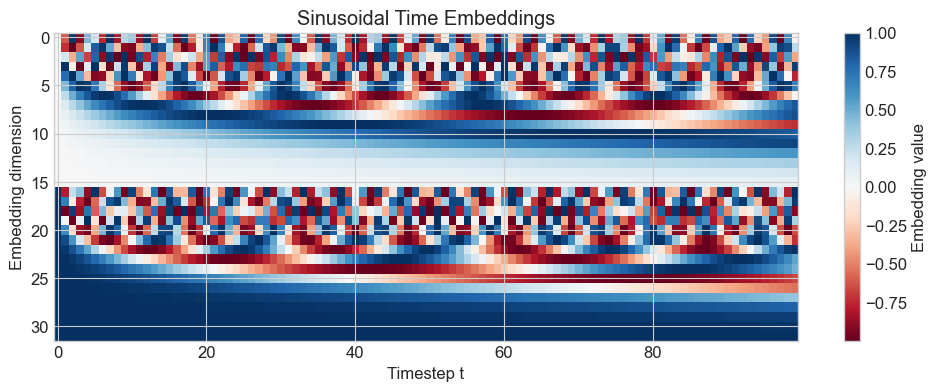

In [6]:
def get_sinusoidal_embedding(t, embed_dim):
    """
    Compute a sinusoidal time embedding (similar to positional encodings in Transformers).
    
    This helps the model understand "how noisy" the input is.
    
    Args:
        t: Timesteps tensor of shape [B] or [B,1]
        embed_dim: Dimension of the embedding
    
    Returns:
        embeddings: Tensor of shape [B, embed_dim]
    """
    if t.dim() == 1:
        t = t.unsqueeze(1)
    half_dim = embed_dim // 2
    device = t.device
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = t * emb  # shape: [B, half_dim]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

# Visualize time embeddings
t_test = torch.linspace(0, 999, 100).unsqueeze(1)
embeddings = get_sinusoidal_embedding(t_test, embed_dim=32)

plt.figure(figsize=(12, 4))
plt.imshow(embeddings.T.numpy(), aspect='auto', cmap='RdBu')
plt.colorbar(label='Embedding value')
plt.xlabel('Timestep t')
plt.ylabel('Embedding dimension')
plt.title('Sinusoidal Time Embeddings')
plt.show()

In [7]:
class DiffusionMLP(nn.Module):
    """
    Simple MLP that predicts the noise given noisy data x_t and timestep t.
    
    Architecture (from Ho et al. 2020):
    - Sinusoidal time embedding
    - Concatenate [x_t, time_embedding]
    - Simple MLP with ReLU activations
    - Output: predicted noise ε_θ
    """
    def __init__(self, input_dim=2, time_embed_dim=32, hidden_dim=128):
        super(DiffusionMLP, self).__init__()
        self.time_embed_dim = time_embed_dim
        self.fc1 = nn.Linear(input_dim + time_embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x, t):
        """
        Args:
            x: Noisy data x_t, shape [B, input_dim]
            t: Timesteps, shape [B] or [B,1]
        Returns:
            noise_pred: Predicted noise, shape [B, input_dim]
        """
        t_emb = get_sinusoidal_embedding(t, self.time_embed_dim)
        h = torch.cat([x, t_emb], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        out = self.fc_out(h)
        return out

# Create model
model = DiffusionMLP(input_dim=2, time_embed_dim=32, hidden_dim=128).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)

Model parameters: 37,762
DiffusionMLP(
  (fc1): Linear(in_features=34, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=2, bias=True)
)


## 7. Training the DDPM

The training loop is simple:

1. Sample a batch of data $x_0$
2. Sample random timesteps $t \sim \text{Uniform}(1, T)$
3. Sample noise $\epsilon \sim \mathcal{N}(0, I)$
4. Compute noisy data: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
5. Predict noise: $\hat{\epsilon} = \epsilon_\theta(x_t, t)$
6. Compute loss: $\mathcal{L} = \|\epsilon - \hat{\epsilon}\|^2$
7. Backpropagate and update

Training DDPM...

Epoch   1/500 | Loss: 0.276234
Epoch  20/500 | Loss: 0.062577
Epoch  40/500 | Loss: 0.064892
Epoch  60/500 | Loss: 0.063286
Epoch  80/500 | Loss: 0.064806
Epoch 100/500 | Loss: 0.052967
Epoch 120/500 | Loss: 0.065589
Epoch 140/500 | Loss: 0.061908
Epoch 160/500 | Loss: 0.061578
Epoch 180/500 | Loss: 0.060594
Epoch 200/500 | Loss: 0.057815
Epoch 220/500 | Loss: 0.060320
Epoch 240/500 | Loss: 0.060724
Epoch 260/500 | Loss: 0.059891
Epoch 280/500 | Loss: 0.058319
Epoch 300/500 | Loss: 0.052494
Epoch 320/500 | Loss: 0.060950
Epoch 340/500 | Loss: 0.060908
Epoch 360/500 | Loss: 0.058764
Epoch 380/500 | Loss: 0.063075
Epoch 400/500 | Loss: 0.060799
Epoch 420/500 | Loss: 0.059070
Epoch 440/500 | Loss: 0.058466
Epoch 460/500 | Loss: 0.057361
Epoch 480/500 | Loss: 0.055147
Epoch 500/500 | Loss: 0.061502


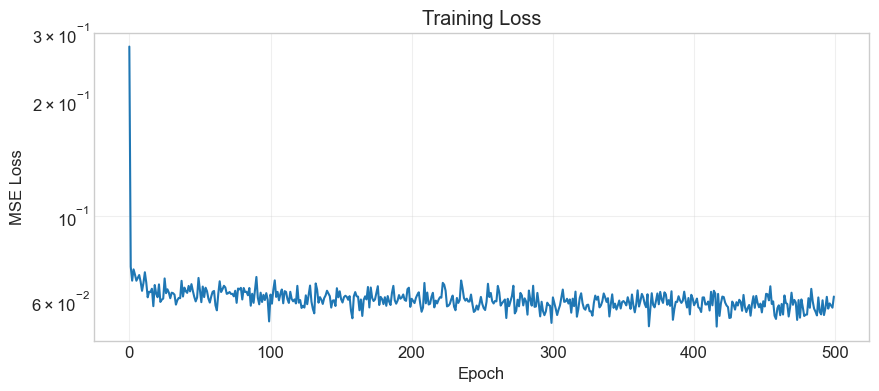

In [8]:
def train_ddpm(model, betas, alpha_cumprod, dataloader, epochs=250, lr=1e-3, device='cpu'):
    """
    Train the DDPM model.
    
    Args:
        model: Noise predictor network
        betas: Beta schedule tensor
        alpha_cumprod: Cumulative product of alphas
        dataloader: DataLoader for training data
        epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on
    
    Returns:
        losses: List of epoch losses
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    T = len(betas)
    losses = []
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        
        for (x_0,) in dataloader:
            x_0 = x_0.to(device)
            batch_size = x_0.shape[0]
            
            # Sample random timesteps (0-indexed)
            t = torch.randint(0, T, (batch_size,), device=device)
            
            # Get alpha_bar for each sample
            alpha_bar_t = alpha_cumprod[t].unsqueeze(1)  # shape: [B, 1]
            
            # Sample noise
            noise = torch.randn_like(x_0)
            
            # Forward process: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
            x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
            
            # Predict noise
            t_float = t.float()
            noise_pred = model(x_t, t_float)
            
            # Compute loss
            loss = F.mse_loss(noise_pred, noise)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * batch_size
        
        epoch_loss = running_loss / len(dataloader.dataset)
        losses.append(epoch_loss)
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {epoch_loss:.6f}")
    
    return losses

# Precompute diffusion coefficients
T = 5000
betas = linear_beta_schedule(T).to(device)
alphas = 1.0 - betas
alpha_cumprod = torch.cumprod(alphas, dim=0).to(device)

# Create dataloader
dataset = TensorDataset(torch.from_numpy(X_train))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Train
print("Training DDPM...\n")
losses = train_ddpm(model, betas, alpha_cumprod, dataloader, epochs=500, lr=1e-3, device=device)

# Plot training curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## 8. Sampling: Generating New Data

To generate new samples, we start from pure noise $x_T \sim \mathcal{N}(0, I)$ and iteratively denoise:

For $t = T, T-1, \ldots, 1$:
1. Predict noise: $\hat{\epsilon} = \epsilon_\theta(x_t, t)$
2. Compute mean: $\mu = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \hat{\epsilon} \right)$
3. Sample: $x_{t-1} = \mu + \sigma_t z$, where $z \sim \mathcal{N}(0, I)$ (except for $t=1$)

In [9]:
@torch.no_grad()
def sample_ddpm(model, T, alphas, alpha_cumprod, betas, device, n_samples=1000, return_trajectory=False):
    """
    Generate samples using the reverse diffusion process (Algorithm 2 from Ho et al. 2020).
    
    Args:
        model: Trained noise predictor
        T: Number of diffusion steps
        alphas: Alpha values (1 - beta)
        alpha_cumprod: Cumulative product of alphas
        betas: Beta schedule
        device: Device to use
        n_samples: Number of samples to generate
        return_trajectory: If True, return intermediate steps
    
    Returns:
        samples: Generated samples, shape (n_samples, 2)
        trajectory (optional): List of intermediate samples
    """
    model.eval()
    
    # Start from pure Gaussian noise: x_T ~ N(0, I)
    x = torch.randn(n_samples, 2, device=device)
    
    trajectory = [x.cpu().numpy()] if return_trajectory else None
    
    # Reverse diffusion: t = T-1, T-2, ..., 0
    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.float32)
        
        # Get coefficients for this timestep
        alpha = alphas[t]
        alpha_bar = alpha_cumprod[t]
        
        if t > 0:
            alpha_bar_prev = alpha_cumprod[t-1]
        else:
            alpha_bar_prev = torch.tensor(1.0, device=device)
        
        # Predict the noise
        noise_pred = model(x, t_tensor)
        
        # Compute the mean: μ = 1/√α * (x_t - (1-α)/√(1-ᾱ) * ε_pred)
        coef = (1 - alpha) / torch.sqrt(1 - alpha_bar)
        mean = (1 / torch.sqrt(alpha)) * (x - coef * noise_pred)
        
        # Add noise for t > 0
        if t > 0:
            # Posterior variance: β̃ = (1 - ᾱ_{t-1}) / (1 - ᾱ_t) * β_t
            beta_tilde = (1 - alpha_bar_prev) / (1 - alpha_bar) * betas[t]
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_tilde) * noise
        else:
            x = mean
        
        # Save trajectory at certain steps
        if return_trajectory and (t % 100 == 0 or t < 10):
            trajectory.append(x.cpu().numpy())
    
    if return_trajectory:
        return x.cpu().numpy(), trajectory
    return x.cpu().numpy()

# Generate samples
print("Generating samples...")
samples, trajectory = sample_ddpm(
    model, T, alphas, alpha_cumprod, betas, device, 
    n_samples=5000, return_trajectory=True
)
print(f"Generated {len(samples)} samples")

Generating samples...
Generated 5000 samples


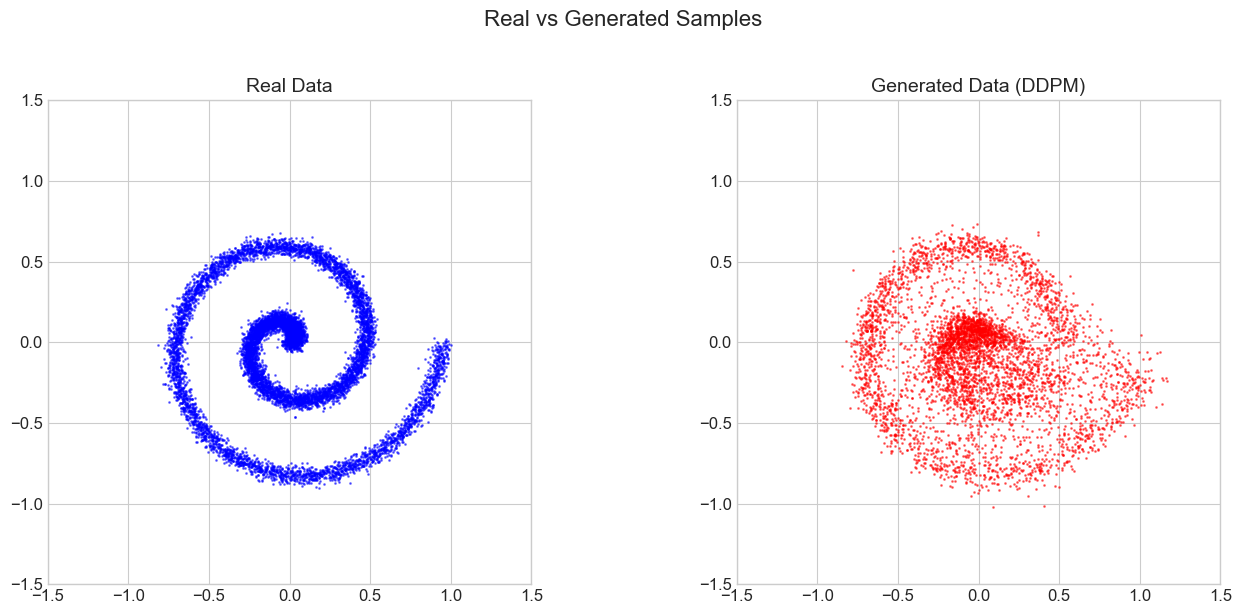

In [10]:
# Compare real and generated data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real data
axes[0].scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.5, c='blue')
axes[0].set_title('Real Data', fontsize=14)
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)
axes[0].set_aspect('equal')

# Generated data
axes[1].scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, c='red')
axes[1].set_title('Generated Data (DDPM)', fontsize=14)
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_ylim(-1.5, 1.5)
axes[1].set_aspect('equal')

plt.suptitle('Real vs Generated Samples', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Visualizing the Reverse Process

Let's see how samples evolve from noise to structured data:

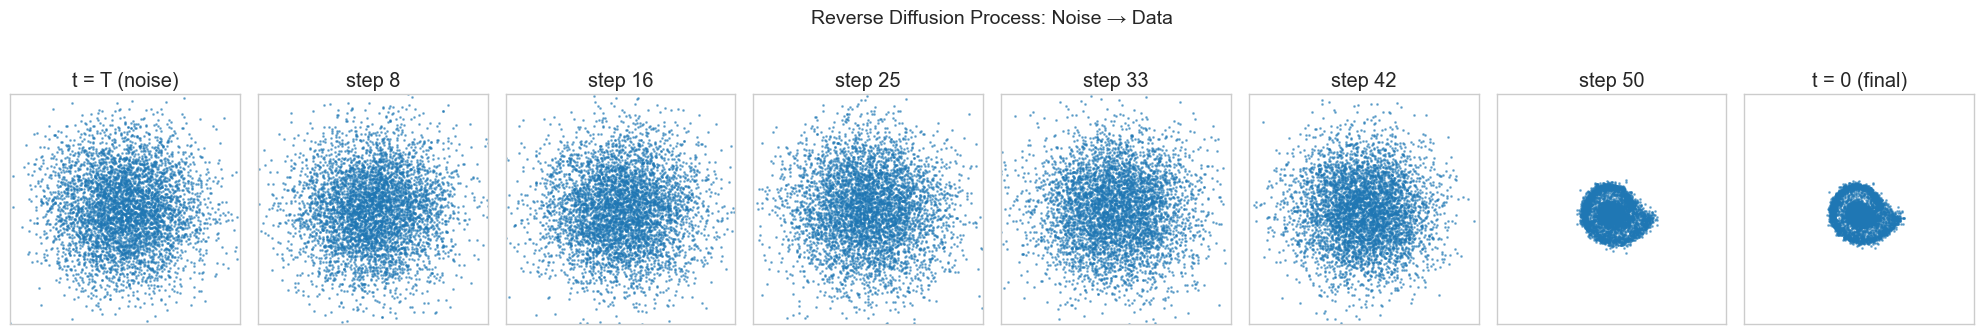

In [11]:
# Show trajectory snapshots
n_snapshots = min(8, len(trajectory))
indices = np.linspace(0, len(trajectory) - 1, n_snapshots, dtype=int)

fig, axes = plt.subplots(1, n_snapshots, figsize=(20, 3.5))

for idx, traj_idx in enumerate(indices):
    data = trajectory[traj_idx]
    axes[idx].scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
    
    # Estimate timestep from index
    if traj_idx == 0:
        step_label = "t = T (noise)"
    elif traj_idx == len(trajectory) - 1:
        step_label = "t = 0 (final)"
    else:
        step_label = f"step {traj_idx}"
    
    axes[idx].set_title(step_label)
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_aspect('equal')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.suptitle('Reverse Diffusion Process: Noise → Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. Experiments and Analysis

### Effect of Number of Diffusion Steps (T)

Generating multiple sample batches to show consistency...


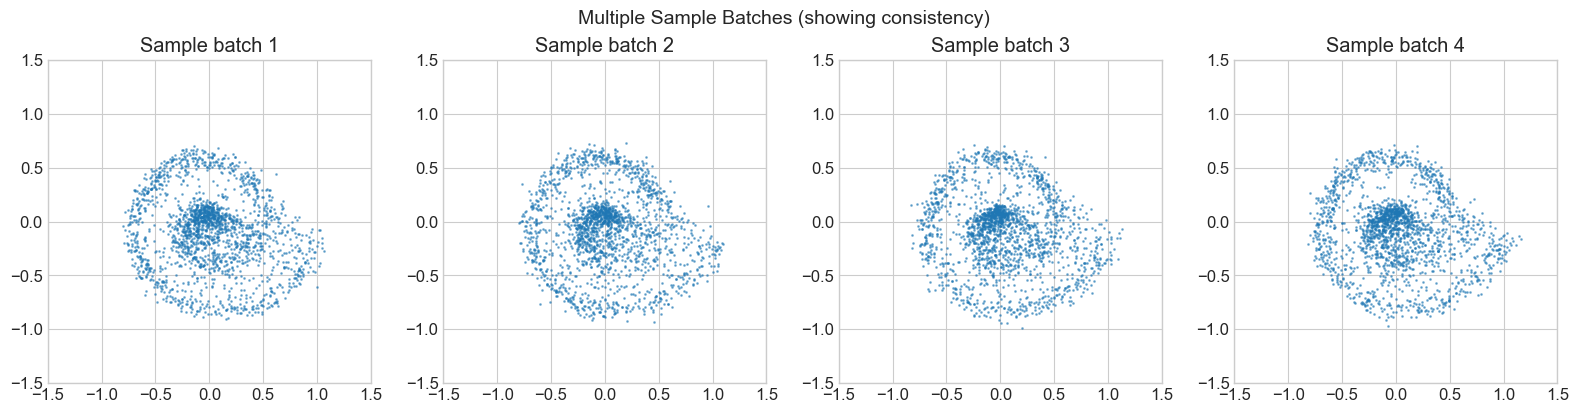

In [12]:
def experiment_timesteps(T_values, n_epochs=100):
    """
    Train models with different numbers of diffusion steps.
    """
    results = {}
    
    for T_exp in T_values:
        print(f"\nTraining with T = {T_exp}")
        
        # Create diffusion coefficients
        betas_exp = linear_beta_schedule(T_exp).to(device)
        alphas_exp = 1.0 - betas_exp
        alpha_cumprod_exp = torch.cumprod(alphas_exp, dim=0).to(device)
        
        # Create model
        m = DiffusionMLP(input_dim=2, time_embed_dim=32, hidden_dim=128).to(device)
        
        # Train
        losses_exp = train_ddpm(m, betas_exp, alpha_cumprod_exp, dataloader, 
                                epochs=n_epochs, lr=1e-3, device=device)
        
        # Generate samples
        samples_exp = sample_ddpm(m, T_exp, alphas_exp, alpha_cumprod_exp, betas_exp, 
                                  device, n_samples=2000)
        
        results[T_exp] = {'losses': losses_exp, 'samples': samples_exp}
    
    return results

# Run experiment (uncomment to run - takes a few minutes)
# T_values = [50, 200, 500, 1000]
# results_T = experiment_timesteps(T_values, n_epochs=100)

# For demonstration, generate samples multiple times to show consistency
print("Generating multiple sample batches to show consistency...")
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx in range(4):
    samples_temp = sample_ddpm(model, T, alphas, alpha_cumprod, betas, device, n_samples=2000)
    
    axes[idx].scatter(samples_temp[:, 0], samples_temp[:, 1], s=1, alpha=0.5)
    axes[idx].set_title(f'Sample batch {idx+1}')
    axes[idx].set_xlim(-1.5, 1.5)
    axes[idx].set_ylim(-1.5, 1.5)
    axes[idx].set_aspect('equal')

plt.suptitle('Multiple Sample Batches (showing consistency)', fontsize=14)
plt.tight_layout()
plt.show()

### Comparing Noise Schedules

Training with COSINE schedule...

Epoch   1/200 | Loss: 0.462200
Epoch  20/200 | Loss: 0.272284
Epoch  40/200 | Loss: 0.274641
Epoch  60/200 | Loss: 0.277682
Epoch  80/200 | Loss: 0.268605
Epoch 100/200 | Loss: 0.263805
Epoch 120/200 | Loss: 0.267853
Epoch 140/200 | Loss: 0.265772
Epoch 160/200 | Loss: 0.252522
Epoch 180/200 | Loss: 0.259330
Epoch 200/200 | Loss: 0.258705


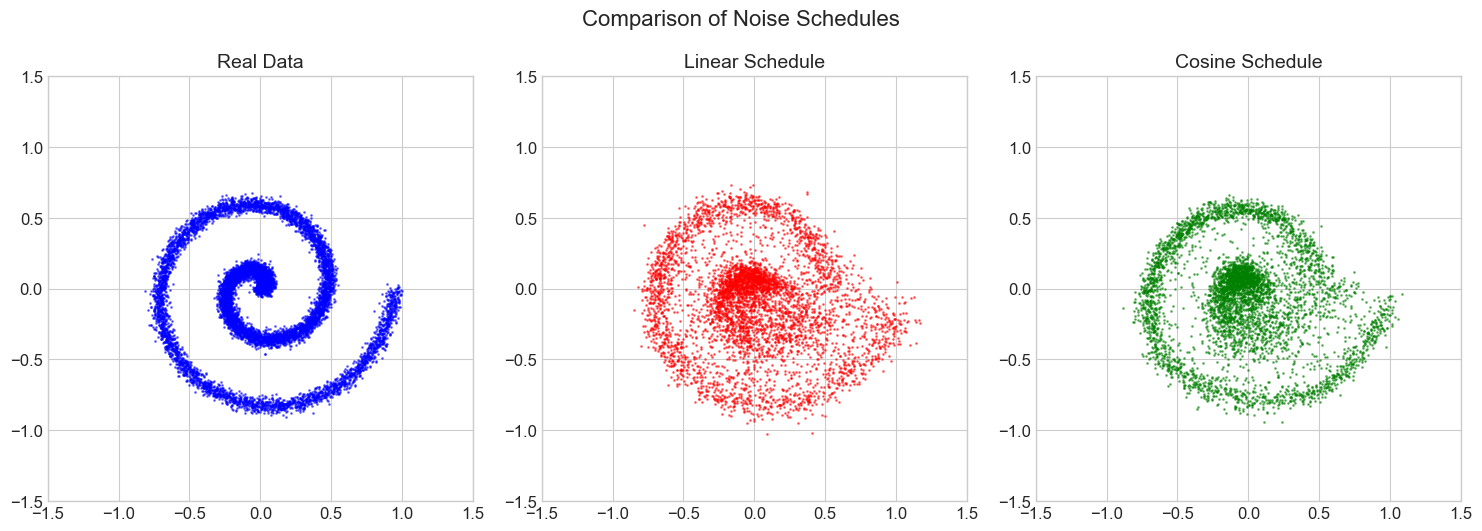

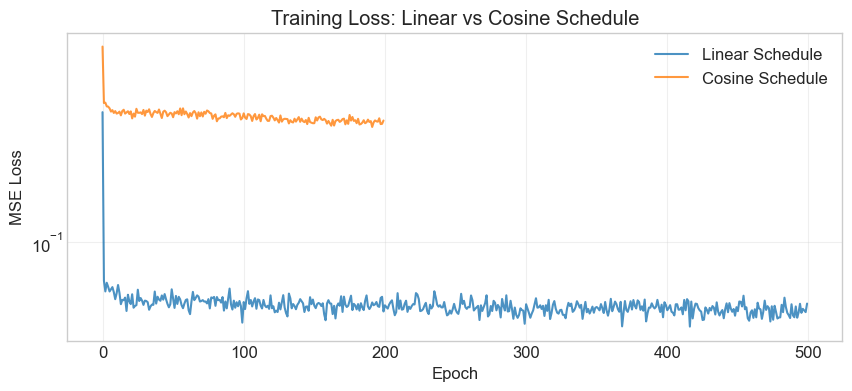

In [13]:
# Train with cosine schedule
print("Training with COSINE schedule...\n")

# Cosine schedule coefficients
betas_cosine = cosine_beta_schedule(T).to(device)
alphas_cosine = 1.0 - betas_cosine
alpha_cumprod_cosine = torch.cumprod(alphas_cosine, dim=0).to(device)

# Create and train model
model_cosine = DiffusionMLP(input_dim=2, time_embed_dim=32, hidden_dim=128).to(device)
losses_cosine = train_ddpm(model_cosine, betas_cosine, alpha_cumprod_cosine, dataloader, 
                           epochs=200, lr=1e-3, device=device)

# Generate samples
samples_cosine = sample_ddpm(model_cosine, T, alphas_cosine, alpha_cumprod_cosine, 
                             betas_cosine, device, n_samples=5000)

# Compare
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.5, c='blue')
axes[0].set_title('Real Data', fontsize=14)

axes[1].scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, c='red')
axes[1].set_title('Linear Schedule', fontsize=14)

axes[2].scatter(samples_cosine[:, 0], samples_cosine[:, 1], s=1, alpha=0.5, c='green')
axes[2].set_title('Cosine Schedule', fontsize=14)

for ax in axes:
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

plt.suptitle('Comparison of Noise Schedules', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Compare training curves
plt.figure(figsize=(10, 4))
plt.plot(losses, label='Linear Schedule', alpha=0.8)
plt.plot(losses_cosine, label='Cosine Schedule', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss: Linear vs Cosine Schedule')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()